In [1]:
import re
import pandas as pd
import seaborn as sns
import numpy as np
import spacy
import unicodedata
import en_core_web_sm
import seaborn as sns
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt  
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.metrics import auc
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import average_precision_score, auc, roc_curve, precision_recall_curve
from textblob import TextBlob
import random
from pandas_profiling import ProfileReport   
#pip install https://github.com/pandas-profiling/pandas-profiling/archive/master.zip

Matplotlib is building the font cache; this may take a moment.


ModuleNotFoundError: No module named 'spacy'

In [3]:
df=pd.read_csv('/Users/anagha/Desktop/Sentiment Analysis/Womens Clothing E-Commerce Reviews.csv')

# Data Cleaning

In [4]:
df.drop(['Age','Clothing ID', 'Division Name', 'Department Name', 'Class Name'], axis = 1, inplace=True)
df.reset_index(inplace=True)
df.drop(['Unnamed: 0'],axis = 1, inplace=True)
df.set_index('index')
index_names = df[df['Review Text'].isnull() & df['Title'].isnull()].index 
df.drop(index_names, inplace = True) 
df[df['Review Text'].isnull() & df['Title'].isnull()].sum(axis=0)
df['Review Text'].isnull().sum(axis = 0)
idx=df[df['Review Text'].isnull()].index
df['Title'].isnull().sum(axis = 0)
df['Review Text'][idx]
df['Title'][idx]
df['Review Text'][idx]=df['Title'][idx]
df['Review Text'][idx]
df.drop(['Title'],axis = 1, inplace=True)

/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


# Text Preprocessing

In [5]:
def strip_accents(text):

    try:
        text = unicode(text, 'utf-8')
    except NameError: # unicode is a default on python 3 
        pass

    text = unicodedata.normalize('NFD', text)\
           .encode('ascii', 'ignore')\
           .decode("utf-8")
    

    return str(text)

df['Review Text Precrocessed']=df['Review Text'].apply(lambda x: strip_accents(x))

# def spell_check(x):
#     x=TextBlob(str(x)).correct()
#     return ''.join(x)

# df['Review Text Precrocessed']=df['Review Text Precrocessed'].apply(lambda x: spell_check(x))


def char_count(x):
    s=x.split()
    s=str(s)
    x=' '.join(s)
    return len(x)

df['Char_Count']=df['Review Text Precrocessed'].apply(lambda x: char_count(x.encode('utf-8')))


def word_count(x):
    return len(str(x).split())

df['Word_Count']=df['Review Text Precrocessed'].apply(lambda x: word_count(x.encode('utf-8')))

def remove_sapce(x):
    x=' '.join(x.split())
    return x
df['Review Text Precrocessed']=df['Review Text Precrocessed'].apply(lambda x: remove_sapce(x))

df['Review Text Precrocessed']=df['Review Text Precrocessed'].str.lower()

contractions = { 
"ain't": "am not / are not / is not / has not / have not",
"aren't": "are not / am not",
"can't": "cannot",
"can't've": "cannot have",
"'cause": "because",
"could've": "could have",
"couldn't": "could not",
"couldn't've": "could not have",
"didn't": "did not",
"doesn't": "does not",
"don't": "do not",
"hadn't": "had not",
"hadn't've": "had not have",
"hasn't": "has not",
"haven't": "have not",
"he'd": "he had / he would",
"he'd've": "he would have",
"he'll": "he shall / he will",
"he'll've": "he shall have / he will have",
"he's": "he has / he is",
"how'd": "how did",
"how'd'y": "how do you",
"how'll": "how will",
"how's": "how has / how is / how does",
"I'd": "I had / I would",
"I'd've": "I would have",
"I'll": "I shall / I will",
"I'll've": "I shall have / I will have",
"I'm": "I am",
"i'm": "i am",
"I've": "I have",
"isn't": "is not",
"it'd": "it had / it would",
"it'd've": "it would have",
"it'll": "it shall / it will",
"it'll've": "it shall have / it will have",
"it's": "it is",
"let's": "let us",
"ma'am": "madam",
"mayn't": "may not",
"might've": "might have",
"mightn't": "might not",
"mightn't've": "might not have",
"must've": "must have",
"mustn't": "must not",
"mustn't've": "must not have",
"needn't": "need not",
"needn't've": "need not have",
"o'clock": "of the clock",
"oughtn't": "ought not",
"oughtn't've": "ought not have",
"shan't": "shall not",
"sha'n't": "shall not",
"shan't've": "shall not have",
"she'd": "she had / she would",
"she'd've": "she would have",
"she'll": "she shall / she will",
"she'll've": "she shall have / she will have",
"she's": "she has / she is",
"should've": "should have",
"shouldn't": "should not",
"shouldn't've": "should not have",
"so've": "so have",
"so's": "so as / so is",
"that'd": "that would / that had",
"that'd've": "that would have",
"that's": "that has / that is",
"there'd": "there had / there would",
"there'd've": "there would have",
"there's": "there has / there is",
"they'd": "they had / they would",
"they'd've": "they would have",
"they'll": "they shall / they will",
"they'll've": "they shall have / they will have",
"they're": "they are",
"they've": "they have",
"to've": "to have",
"wasn't": "was not",
"we'd": "we had / we would",
"we'd've": "we would have",
"we'll": "we will",
"we'll've": "we will have",
"we're": "we are",
"we've": "we have",
"weren't": "were not",
"what'll": "what shall / what will",
"what'll've": "what shall have / what will have",
"what're": "what are",
"what's": "what has / what is",
"what've": "what have",
"when's": "when has / when is",
"when've": "when have",
"where'd": "where did",
"where's": "where has / where is",
"where've": "where have",
"who'll": "who shall / who will",
"who'll've": "who shall have / who will have",
"who's": "who has / who is",
"who've": "who have",
"why's": "why has / why is",
"why've": "why have",
"will've": "will have",
"won't": "will not",
"won't've": "will not have",
"would've": "would have",
"wouldn't": "would not",
"wouldn't've": "would not have",
"y'all": "you all",
"y'all'd": "you all would",
"y'all'd've": "you all would have",
"y'all're": "you all are",
"y'all've": "you all have",
"you'd": "you had / you would",
"you'd've": "you would have",
"you'll": "you shall / you will",
"you'll've": "you shall have / you will have",
"you're": "you are",
"you've": "you have"
}

for key, value in contractions.items():
  key= key.lower()
  value=value.lower()
  
def cont_to_exp(x):
    if type(x) is str:
        for key in contractions:
            value=contractions[key]
            x=x.replace(key,value)
        return x
    return x
df['Review Text Precrocessed']=df['Review Text Precrocessed'].apply(lambda x: cont_to_exp(x))


def puntuation_removal(x):
    x=re.sub(r'[^\w]+', " ", x)
    return x

df['Review Text Precrocessed']=df['Review Text Precrocessed'].apply(lambda x: puntuation_removal(str(x)))

In [6]:
df.head(10)

,index,Review Text,Rating,Recommended IND,Positive Feedback Count,Review Text Precrocessed,Char_Count,Word_Count
0,0,Absolutely wonderful - silky and sexy and comf...,4,1,0,absolutely wonderful silky and sexy and comfor...,155,8
1,1,Love this dress! it's sooo pretty. i happene...,5,1,4,love this dress it is sooo pretty i happened t...,971,62
2,2,I had such high hopes for this dress and reall...,3,0,0,i had such high hopes for this dress and reall...,1589,98
3,3,"I love, love, love this jumpsuit. it's fun, fl...",5,1,0,i love love love this jumpsuit it is fun flirt...,381,22
4,4,This shirt is very flattering to all due to th...,5,1,6,this shirt is very flattering to all due to th...,601,36
5,5,"I love tracy reese dresses, but this one is no...",2,0,4,i love tracy reese dresses but this one is not...,1565,98
6,6,I aded this in my basket at hte last mintue to...,5,1,1,i aded this in my basket at hte last mintue to...,1599,101
7,7,"I ordered this in carbon for store pick up, an...",4,1,4,i ordered this in carbon for store pick up and...,1547,97
8,8,I love this dress. i usually get an xs but it ...,5,1,0,i love this dress i usually get an xs but it r...,537,34
9,9,"I'm 5""5' and 125 lbs. i ordered the s petite t...",5,1,0,i am 5 5 and 125 lbs i ordered the s petite to...,1155,72


In [7]:
df['Review Text Precrocessed']

0        absolutely wonderful silky and sexy and comfor...
1        love this dress it is sooo pretty i happened t...
2        i had such high hopes for this dress and reall...
3        i love love love this jumpsuit it is fun flirt...
4        this shirt is very flattering to all due to th...
5        i love tracy reese dresses but this one is not...
6        i aded this in my basket at hte last mintue to...
7        i ordered this in carbon for store pick up and...
8        i love this dress i usually get an xs but it r...
9        i am 5 5 and 125 lbs i ordered the s petite to...
10       dress runs small esp where the zipper area run...
11       this dress is perfection so pretty and flatter...
12       more and more i find myself reliant on the rev...
13       bought the black xs to go under the larkspur m...
14       this is a nice choice for holiday gatherings i...
15       i took these out of the package and wanted the...
16       material and color is nice the leg opening is .

# Tokennization

In [8]:
def tokenize(x):
    x= TextBlob(str(x)).words
    return x
# df['Review Text Precrocessed']=df['Review Text Precrocessed'].apply(lambda x: tokenize(x))

# Lemmatization

In [9]:
nlp = spacy.load('en_core_web_sm')
def make_to_base(x):
    x_list=[]
    doc=nlp(x)
    for token in doc:
        lemma=token.lemma_
        
        if lemma=='_PRON_' or lemma == 'be' or lemma == 'is': 
            lemma=token.text
            
        
        x_list.append(lemma)
    return ' '.join(x_list)

df['Review Text Precrocessed']=df['Review Text Precrocessed'].apply(lambda x: make_to_base(x.decode("utf-8")))

In [10]:
df.head(10)

,index,Review Text,Rating,Recommended IND,Positive Feedback Count,Review Text Precrocessed,Char_Count,Word_Count
0,0,Absolutely wonderful - silky and sexy and comf...,4,1,0,absolutely wonderful silky and sexy and comfor...,155,8
1,1,Love this dress! it's sooo pretty. i happene...,5,1,4,love this dress -PRON- is sooo pretty i happen...,971,62
2,2,I had such high hopes for this dress and reall...,3,0,0,i have such high hope for this dress and reall...,1589,98
3,3,"I love, love, love this jumpsuit. it's fun, fl...",5,1,0,i love love love this jumpsuit -PRON- is fun f...,381,22
4,4,This shirt is very flattering to all due to th...,5,1,6,this shirt is very flattering to all due to th...,601,36
5,5,"I love tracy reese dresses, but this one is no...",2,0,4,i love tracy reese dress but this one is not f...,1565,98
6,6,I aded this in my basket at hte last mintue to...,5,1,1,i ad this in -PRON- basket at hte last mintue ...,1599,101
7,7,"I ordered this in carbon for store pick up, an...",4,1,4,i order this in carbon for store pick up and h...,1547,97
8,8,I love this dress. i usually get an xs but it ...,5,1,0,i love this dress i usually get an xs but -PRO...,537,34
9,9,"I'm 5""5' and 125 lbs. i ordered the s petite t...",5,1,0,i am 5 5 and 125 lb i order the s petite to ma...,1155,72


# Label Generation

In [11]:
def la(x):
    if(x>3):
        return 1
    else:
        return 0
    
df['Label']=df['Rating'].apply(lambda x:la(x))
Positive_review_1=[]
Negative_review_1=[]
Positive_review_1=df[df['Label']==1]
Negative_review_1=df[df['Label']==0]


In [12]:
def label(x):
    if(x>3):
        return 1
    elif(x==3):
        return 2
    else:
        return 0

df['Label_3C']=df['Rating'].apply(lambda x:label(x))
Positive_review=[]
Negative_review=[]
Neutral_review=[]
Positive_review=df[df['Label_3C']==1]
Negative_review=df[df['Label_3C']==0]
Neutral_review=df[df['Label_3C']==2]


# TFIDF Vector Generation

In [13]:
stopwords = ['a', 'about', 'an', 'and', 'are', 'as', 'at', 'be', 'been', 'but', 'by', 'can', \
             'even', 'ever', 'for', 'from', 'get', 'had', 'has', 'have', 'he', 'her', 'hers', 'his', \
             'how', 'i', 'if', 'in', 'into', 'is', 'it', 'its', 'just', 'me', 'my', 'of', 'on', 'or', \
             'see', 'seen', 'she', 'so', 'than', 'that', 'the', 'their', 'there', 'they', 'this', \
             'to', 'was', 'we', 'were', 'what', 'when', 'which', 'who', 'will', 'with', 'you','-PRON-']


from sklearn.feature_extraction.text import TfidfVectorizer
tfidf=TfidfVectorizer(stop_words=stopwords, tokenizer= tokenize, ngram_range=(1, 2), max_df=0.9, min_df=3, sublinear_tf=True)
X=tfidf.fit_transform(df['Review Text Precrocessed'])
X.shape

(22642, 47663)

In [14]:
yes=pd.DataFrame(X.toarray(), columns=tfidf.get_feature_names())
yes.head(5)

,0,0 00,0 109lbs,0 110,0 120,0 125,0 2,0 5,0 am,0 because,...,zipper split,zipper stick,zipper style,zipper up,zipper very,zipper work,zipper would,zone,zoom,zoom pron
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Splitting Data

In [15]:
y=df['Label']
X=X
X_train, X_test, y_train, y_test=train_test_split(X,y,test_size=.20,random_state=0)

In [ ]:
#y_test

# ROC and Confusion Matrix

In [94]:
def get_ROC(y_test, y_pred):
    
    # Compute ROC and plot curve
    
    fpr_rf, tpr_rf, _ = roc_curve(y_test, y_pred)
    roc_auc_rf = auc(fpr_rf, tpr_rf)
    #plt.figure(figsize=(8,8))
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.plot(fpr_rf, tpr_rf, lw=1, label='{} curve (AUC = {:0.2f})'.format('RF',roc_auc_rf))
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate', fontsize=16)
    plt.title('ROC curve', fontsize=16)
    plt.legend(loc='lower right', fontsize=13)
    plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
    plt.axes().set_aspect('equal')
    plt.show()
    
def get_ROC_multiclass(y_test, y_pred):
    
    #Compute ROC and plot curve for three classes
    
    n_classes=3
    # roc curve
    fpr = dict()
    tpr = dict()
    aucroc=dict()

    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test[:, i],
                                  y_pred[:, i])
        aucroc[i] = auc(fpr[i], tpr[i])
        plt.plot(fpr[i], tpr[i], lw=2, label='class {} (AUC = {:0.2f})'.format(i, aucroc[i] ))

    plt.xlabel("false positive rate")
    plt.ylabel("true positive rate")
    plt.legend(loc="best")
    plt.title("ROC curve")
    plt.show()


def get_Precision_Recall(y_test, y_pred):
    
    # Compute Precision-Recall and plot curve
    
    precision, recall, thresholds = precision_recall_curve(y_test, y_pred)
    area = auc(recall, precision)
    print("Area Under Curve: %0.2f" % area)
    plt.clf()
    plt.plot(recall, precision, label='Precision-Recall curve')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title('Precision-Recall example: AUC=%0.2f' % area)
    plt.legend(loc="lower left")
    plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
    plt.axes().set_aspect('equal')
    plt.show()
    
    
def get_Precision_Recall_multiclass(y_test, y_pred):
    
    precision = dict()
    recall = dict()
    area=dict()
    n_classes=3
    for i in range(n_classes):
        precision[i], recall[i], _ = precision_recall_curve(y_test[:, i],
                                                        y_pred[:, i])
        area[i] = auc(precision[i], recall[i])
        plt.plot(recall[i], precision[i], lw=2, label='class {} (AUC = {:0.2f})'.format(i, area[i]))
        

    plt.xlabel("recall")
    plt.ylabel("precision")
    plt.legend(loc="best")
    plt.title("precision vs. recall curve")
    plt.show()
        
    
def get_Confusion_Matrix(y_test, y_pred):
    
    # Compute and plot Confusion Matrix 
    
    mat = confusion_matrix(y_test, y_pred)
    sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
        xticklabels='auto', yticklabels='auto')
    plt.xlabel('true label')
    plt.ylabel('predicted label');
    plt.show()
    

# Random Forest

## Binary Classification

[[ 457  604]
 [ 152 3316]]
             precision    recall  f1-score   support

          0       0.75      0.43      0.55      1061
          1       0.85      0.96      0.90      3468

avg / total       0.82      0.83      0.82      4529

Accuracy Score: 0.833075734158
F1 Score: 0.897671900379
Average precision-recall score: 0.842403853077


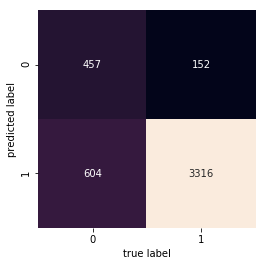

Area Under Curve: 0.92


/anaconda2/lib/python2.7/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


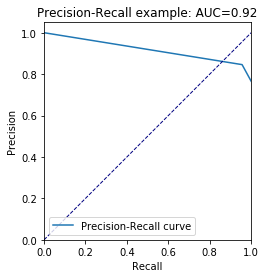

/anaconda2/lib/python2.7/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


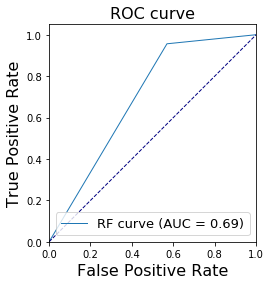

(array([[ 457,  604],
        [ 152, 3316]]),
 u'             precision    recall  f1-score   support\n\n          0       0.75      0.43      0.55      1061\n          1       0.85      0.96      0.90      3468\n\navg / total       0.82      0.83      0.82      4529\n')

In [17]:
def RandomForestBinaryClassifier(X_train, y_train, X_test, y_test):
    
    clf = RandomForestClassifier()
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    Confusion_matrix = confusion_matrix(y_test, y_pred)
    Classification_report = classification_report(y_test, y_pred)
    print(confusion_matrix(y_test, y_pred))
    print(classification_report(y_test, y_pred))
    Accuracy_score = accuracy_score(y_test, y_pred)
    print('Accuracy Score: {}'.format(Accuracy_score))
    F1_score = f1_score(y_test, y_pred)
    print('F1 Score: {}'.format(F1_score))
    Average_precision = average_precision_score(y_test, y_pred)
    print('Average precision-recall score: {}'.format(Average_precision))
    get_Confusion_Matrix(y_test, y_pred)
    get_Precision_Recall(y_test, y_pred)
    get_ROC(y_test, y_pred)
    return Confusion_matrix, Classification_report

RandomForestBinaryClassifier(X_train, y_train, X_test, y_test)

# Binary Classification with Hyperparameter Tuning

[[ 563  498]
 [ 201 3267]]
             precision    recall  f1-score   support

          0       0.74      0.53      0.62      1061
          1       0.87      0.94      0.90      3468

avg / total       0.84      0.85      0.84      4529

Accuracy Score: 0.845661293884
F1 Score: 0.903359601825
Average precision-recall score: 0.861817485068


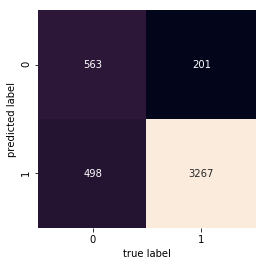

Area Under Curve: 0.93


/anaconda2/lib/python2.7/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


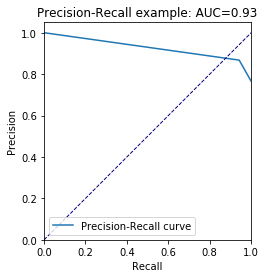

/anaconda2/lib/python2.7/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


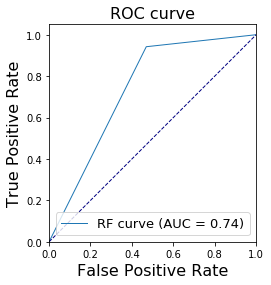

(array([[ 563,  498],
        [ 201, 3267]]),
 u'             precision    recall  f1-score   support\n\n          0       0.74      0.53      0.62      1061\n          1       0.87      0.94      0.90      3468\n\navg / total       0.84      0.85      0.84      4529\n')

In [87]:
def RandomForestBinaryClassifierTuned(X_train, y_train, X_test, y_test, max_features):
    clf = RandomForestClassifier(min_samples_leaf = 1, n_estimators =25, min_samples_split =8, criterion= 'gini', max_features=max_features, max_depth= 40)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    Confusion_matrix = confusion_matrix(y_test, y_pred)
    Classification_report = classification_report(y_test, y_pred)
    print(confusion_matrix(y_test, y_pred))
    print(classification_report(y_test, y_pred))
    Accuracy_score = accuracy_score(y_test, y_pred)
    print('Accuracy Score: {}'.format(Accuracy_score))
    F1_score = f1_score(y_test, y_pred)
    print('F1 Score: {}'.format(F1_score))
    Average_precision = average_precision_score(y_test, y_pred)
    print('Average precision-recall score: {}'.format(Average_precision))
    get_Confusion_Matrix(y_test, y_pred)
    get_Precision_Recall(y_test, y_pred)
    get_ROC(y_test, y_pred)
    return Confusion_matrix, Classification_report
    
RandomForestBinaryClassifierTuned(X_train, y_train, X_test, y_test, 25000)

# Data Split for Three Classes

In [19]:
y_3c=df['Label_3C']
X_3c=X

X_train_3c, X_test_3c, y_train_3c, y_test_3c = train_test_split(X_3c ,y_3c ,test_size=.20, random_state=0)
print(df['Label_3C'].value_counts())

1    17449
2     2823
0     2370
Name: Label_3C, dtype: int64


In [20]:
y_dummy=label_binarize(y_3c, classes=[0,1,2])
X_3c=X

X_train_dummy, X_test_dummy, y_train_dummy, y_test_dummy = train_test_split(X_3c, y_dummy ,test_size=.20, random_state=0)

## Random Forest for Three Classes

Build random Forest Classifier 
[[ 106  365   24]
 [  23 3427   18]
 [  55  482   29]]
             precision    recall  f1-score   support

          0       0.58      0.21      0.31       495
          1       0.80      0.99      0.89      3468
          2       0.41      0.05      0.09       566

avg / total       0.73      0.79      0.72      4529

Accuracy Score: 0.786487083241
F1 Score: 0.786487083241


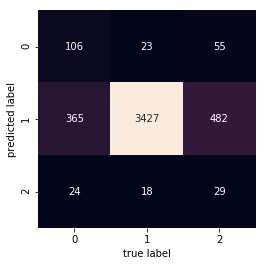

(18113, 47663)
(18113, 3)


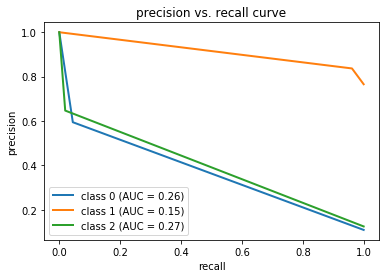

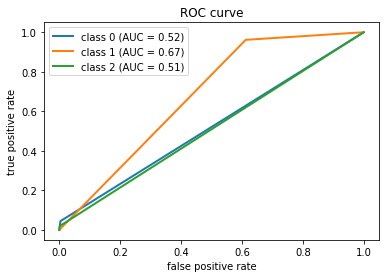

Average precision-recall score: 0.669931593455


0.6699315934546489

In [95]:
print("Build random Forest Classifier ")
clf_3c = RandomForestClassifier()

def RandomForest_ThreeClass(X_train_3c, X_test_3c, y_train_3c, y_test_3c):    
    clf_3c.fit(X_train_3c, y_train_3c)
    y_pred_3c = clf_3c.predict(X_test_3c)
    Confusion_matrix = confusion_matrix(y_test_3c, y_pred_3c)
    Classification_report = classification_report(y_test_3c, y_pred_3c)
    print(confusion_matrix(y_test_3c, y_pred_3c))
    print(classification_report(y_test_3c, y_pred_3c))
    Accuracy_score = accuracy_score(y_test_3c, y_pred_3c)
    print('Accuracy Score: {}'.format(Accuracy_score))
    F1_score = f1_score(y_test_3c, y_pred_3c, average='micro')
    print('F1 Score: {}'.format(F1_score))
    get_Confusion_Matrix(y_test_3c, y_pred_3c)
    return Confusion_matrix

def RandomForest_ThreeClass_plots(X_train_dummy, X_test_dummy, y_train_dummy, y_test_dummy):
    print(X_train_dummy.shape)
    print(y_train_dummy.shape)
    clf_3c.fit(X_train_dummy, y_train_dummy)
    y_pred_dummy = clf_3c.predict(X_test_dummy)
    get_Precision_Recall_multiclass(y_test_dummy, y_pred_dummy)
    get_ROC_multiclass(y_test_dummy, y_pred_dummy)

    Average_precision = average_precision_score(y_test_dummy, y_pred_dummy, average='weighted')
    print('Average precision-recall score: {}'.format(Average_precision))
    return Average_precision
    
RandomForest_ThreeClass(X_train_3c, X_test_3c, y_train_3c, y_test_3c)  
RandomForest_ThreeClass_plots(X_train_dummy, X_test_dummy, y_train_dummy, y_test_dummy)

## Random Forest for Three Classes with Hyperparameter Tuning

Build random Forest Classifier 
[[ 138  277   80]
 [  57 3333   78]
 [  94  378   94]]
             precision    recall  f1-score   support

          0       0.48      0.28      0.35       495
          1       0.84      0.96      0.89      3468
          2       0.37      0.17      0.23       566

avg / total       0.74      0.79      0.75      4529

Accuracy Score: 0.787149481122
F1 Score: 0.787149481122


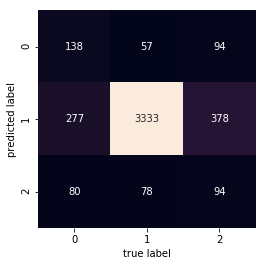

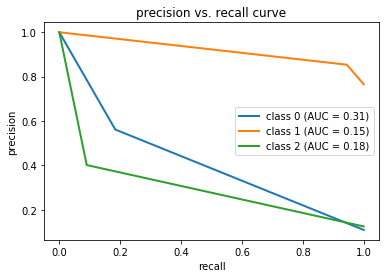

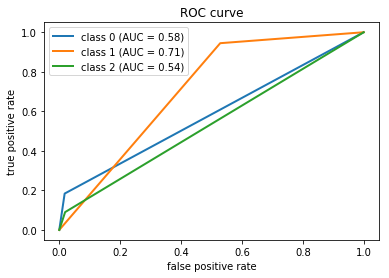

Average precision-recall score: [0.19247015 0.84891673 0.14989594]


array([0.19247015, 0.84891673, 0.14989594])

In [96]:
print("Build random Forest Classifier ")

def RandomForest_ThreeClass_Tuned(X_train_3c, X_test_3c, y_train_3c, y_test_3c, max_features): 
    clf_3c = RandomForestClassifier(min_samples_leaf = 2, n_estimators =15, min_samples_split =8, criterion= 'gini', max_features=max_features, max_depth= 39)
    clf_3c.fit(X_train_3c, y_train_3c)
    y_pred_3c = clf_3c.predict(X_test_3c)
    Confusion_matrix = confusion_matrix(y_test_3c, y_pred_3c)
    Classification_report = classification_report(y_test_3c, y_pred_3c)
    print(confusion_matrix(y_test_3c, y_pred_3c))
    print(classification_report(y_test_3c, y_pred_3c))
    Accuracy_score = accuracy_score(y_test_3c, y_pred_3c)
    print('Accuracy Score: {}'.format(Accuracy_score))
    F1_score = f1_score(y_test_3c, y_pred_3c, average='micro')
    print('F1 Score: {}'.format(F1_score))
    get_Confusion_Matrix(y_test_3c, y_pred_3c)
    return Confusion_matrix

def RandomForest_ThreeClass_Tuned_plots(X_train_dummy, X_test_dummy, y_train_dummy, y_test_dummy, max_features):
    clf_3c = RandomForestClassifier(min_samples_leaf = 2, n_estimators =15, min_samples_split =8, criterion= 'gini', max_features=max_features, max_depth= 39)
    clf_3c.fit(X_train_dummy, y_train_dummy)
    y_pred_dummy = clf_3c.predict(X_test_dummy)
    get_Precision_Recall_multiclass(y_test_dummy, y_pred_dummy)
    get_ROC_multiclass(y_test_dummy, y_pred_dummy)

    Average_precision = average_precision_score(y_test_dummy, y_pred_dummy, average=None)
    print('Average precision-recall score: {}'.format(Average_precision))
    return Average_precision
    
RandomForest_ThreeClass_Tuned(X_train_3c, X_test_3c, y_train_3c, y_test_3c, 20000)  
RandomForest_ThreeClass_Tuned_plots(X_train_dummy, X_test_dummy, y_train_dummy, y_test_dummy, 20000)

# SVM

## SVM for Binary Classification 

[[   0 1061]
 [   0 3468]]
             precision    recall  f1-score   support

          0       0.00      0.00      0.00      1061
          1       0.77      1.00      0.87      3468

avg / total       0.59      0.77      0.66      4529

Accuracy Score: 0.765731949658
F1 Score: 0.867325246968
Average precision-recall score: 0.765731949658


/anaconda2/lib/python2.7/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda2/lib/python2.7/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


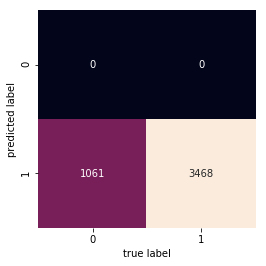

/anaconda2/lib/python2.7/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


Area Under Curve: 0.88


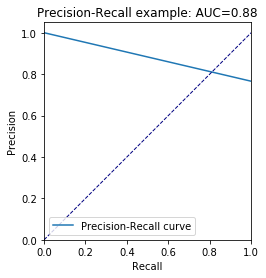

/anaconda2/lib/python2.7/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


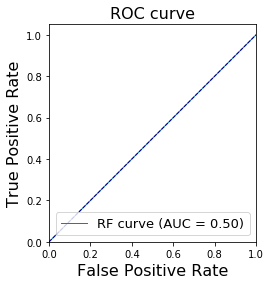

(array([[   0, 1061],
        [   0, 3468]]),
 u'             precision    recall  f1-score   support\n\n          0       0.00      0.00      0.00      1061\n          1       0.77      1.00      0.87      3468\n\navg / total       0.59      0.77      0.66      4529\n')

In [23]:
def svm_binary_classification(X_train, y_train, X_test, y_test):
    clf_svm=SVC()
    clf_svm.fit(X_train, y_train)
    pre=clf_svm.predict(X_test)
    Confusion_matrix = confusion_matrix(y_test, pre)
    Classification_report = classification_report(y_test, pre)
    print(confusion_matrix(y_test,pre))
    print(classification_report(y_test, pre))
    Accuracy_score = accuracy_score(y_test, pre)
    print('Accuracy Score: {}'.format(Accuracy_score))
    F1_score = f1_score(y_test, pre)
    print('F1 Score: {}'.format(F1_score))
    Average_precision = average_precision_score(y_test, pre)
    print('Average precision-recall score: {}'.format(Average_precision))
    get_Confusion_Matrix(y_test, pre)
    get_Precision_Recall(y_test, pre)
    get_ROC(y_test, pre)
    return Confusion_matrix, Classification_report

svm_binary_classification(X_train, y_train, X_test, y_test)

## SVM for Binary Classification with Hyperparameter Tuning

[[ 677  384]
 [ 150 3318]]
             precision    recall  f1-score   support

          0       0.82      0.64      0.72      1061
          1       0.90      0.96      0.93      3468

avg / total       0.88      0.88      0.88      4529

Accuracy Score: 0.882093177302
F1 Score: 0.925523012552
Average precision-recall score: 0.890626076964


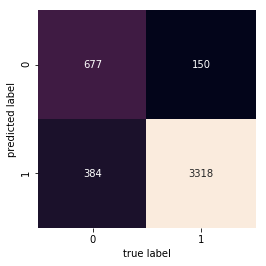

Area Under Curve: 0.94


/anaconda2/lib/python2.7/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


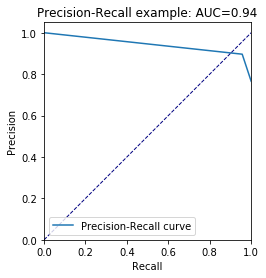

/anaconda2/lib/python2.7/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


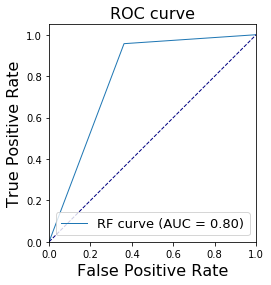

(array([[ 677,  384],
        [ 150, 3318]]),
 u'             precision    recall  f1-score   support\n\n          0       0.82      0.64      0.72      1061\n          1       0.90      0.96      0.93      3468\n\navg / total       0.88      0.88      0.88      4529\n')

In [24]:
def svm_binary_classification_tuned(X_train, y_train, X_test, y_test):
    clf_svm=SVC(C=1.5, gamma=1, kernel='rbf')
    clf_svm.fit(X_train, y_train)
    pre=clf_svm.predict(X_test)
    Confusion_matrix = confusion_matrix(y_test, pre)
    Classification_report = classification_report(y_test, pre)
    print(confusion_matrix(y_test,pre))
    print(classification_report(y_test, pre))
    Accuracy_score = accuracy_score(y_test, pre)
    print('Accuracy Score: {}'.format(Accuracy_score))
    F1_score = f1_score(y_test, pre)
    print('F1 Score: {}'.format(F1_score))
    Average_precision = average_precision_score(y_test, pre)
    print('Average precision-recall score: {}'.format(Average_precision))
    get_Confusion_Matrix(y_test, pre)
    get_Precision_Recall(y_test, pre)
    get_ROC(y_test, pre)
    return Confusion_matrix, Classification_report

svm_binary_classification_tuned(X_train, y_train, X_test, y_test)

## SVM for Three Classes 

Build SVM Classifier 
[[   0  495    0]
 [   0 3468    0]
 [   0  566    0]]
             precision    recall  f1-score   support

          0       0.00      0.00      0.00       495
          1       0.77      1.00      0.87      3468
          2       0.00      0.00      0.00       566

avg / total       0.59      0.77      0.66      4529

Accuracy Score: 0.765731949658
F1 Score: 0.765731949658


/anaconda2/lib/python2.7/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda2/lib/python2.7/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


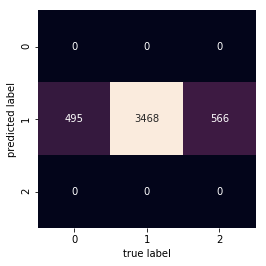

(18113, 47663)
(18113, 3)


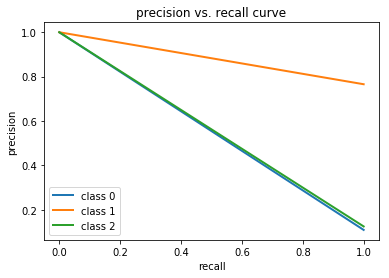

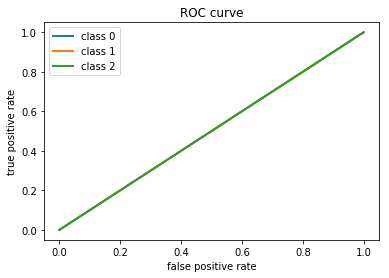

Average precision-recall score: 0.613909058675


0.6139090586749381

In [25]:
print("Build SVM Classifier ")
svm_3c = OneVsRestClassifier(SVC(random_state=0))

def SVM_ThreeClass(X_train_3c, X_test_3c, y_train_3c, y_test_3c):    
    svm_3c.fit(X_train_3c, y_train_3c)
    y_pred_3c = svm_3c.predict(X_test_3c)
    Confusion_matrix = confusion_matrix(y_test_3c, y_pred_3c)
    Classification_report = classification_report(y_test_3c, y_pred_3c)
    print(confusion_matrix(y_test_3c, y_pred_3c))
    print(classification_report(y_test_3c, y_pred_3c))
    Accuracy_score = accuracy_score(y_test_3c, y_pred_3c)
    print('Accuracy Score: {}'.format(Accuracy_score))
    F1_score = f1_score(y_test_3c, y_pred_3c, average='micro')
    print('F1 Score: {}'.format(F1_score))
    get_Confusion_Matrix(y_test_3c, y_pred_3c)
    return Confusion_matrix

def SVM_ThreeClass_plots(X_train_dummy, X_test_dummy, y_train_dummy, y_test_dummy):
    print(X_train_dummy.shape)
    print(y_train_dummy.shape)
    svm_3c.fit(X_train_dummy, y_train_dummy)
    y_pred_dummy = svm_3c.predict(X_test_dummy)
    get_Precision_Recall_multiclass(y_test_dummy, y_pred_dummy)
    get_ROC_multiclass(y_test_dummy, y_pred_dummy)

    Average_precision = average_precision_score(y_test_dummy, y_pred_dummy, average='weighted')
    print('Average precision-recall score: {}'.format(Average_precision))
    return Average_precision
    
SVM_ThreeClass(X_train_3c, X_test_3c, y_train_3c, y_test_3c)  
SVM_ThreeClass_plots(X_train_dummy, X_test_dummy, y_train_dummy, y_test_dummy)

## SVM for Three Classes with Hyperparameter Tuning

Build SVM Classifier 
[[ 256  147   92]
 [  35 3364   69]
 [ 128  318  120]]
             precision    recall  f1-score   support

          0       0.61      0.52      0.56       495
          1       0.88      0.97      0.92      3468
          2       0.43      0.21      0.28       566

avg / total       0.79      0.83      0.80      4529

Accuracy Score: 0.825789357474
F1 Score: 0.825789357474


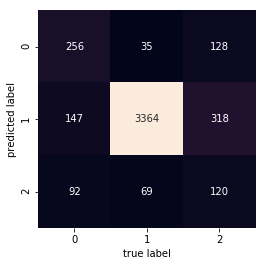

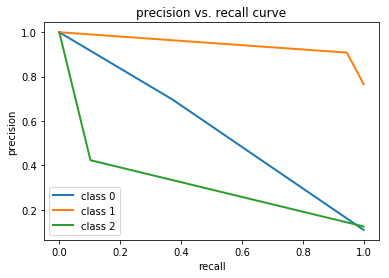

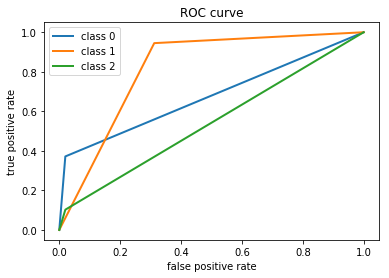

Average precision-recall score: 0.744732839136


0.7447328391359768

In [27]:
print("Build SVM Classifier ")
svm_3c = OneVsRestClassifier(SVC(C=1.3,kernel='linear',random_state=0))

def SVM_ThreeClass_Tuned(X_train_3c, X_test_3c, y_train_3c, y_test_3c):    
    svm_3c.fit(X_train_3c, y_train_3c)
    y_pred_3c = svm_3c.predict(X_test_3c)
    Confusion_matrix = confusion_matrix(y_test_3c, y_pred_3c)
    Classification_report = classification_report(y_test_3c, y_pred_3c)
    print(confusion_matrix(y_test_3c, y_pred_3c))
    print(classification_report(y_test_3c, y_pred_3c))
    Accuracy_score = accuracy_score(y_test_3c, y_pred_3c)
    print('Accuracy Score: {}'.format(Accuracy_score))
    F1_score = f1_score(y_test_3c, y_pred_3c, average='micro')
    print('F1 Score: {}'.format(F1_score))
    get_Confusion_Matrix(y_test_3c, y_pred_3c)
    return Confusion_matrix

def SVM_ThreeClass_plots_Tuned(X_train_dummy, X_test_dummy, y_train_dummy, y_test_dummy):
    svm_3c.fit(X_train_dummy, y_train_dummy)
    y_pred_dummy = svm_3c.predict(X_test_dummy)
    get_Precision_Recall_multiclass(y_test_dummy, y_pred_dummy)
    get_ROC_multiclass(y_test_dummy, y_pred_dummy)

    Average_precision = average_precision_score(y_test_dummy, y_pred_dummy, average='weighted')
    print('Average precision-recall score: {}'.format(Average_precision))
    return Average_precision
    
SVM_ThreeClass_Tuned(X_train_3c, X_test_3c, y_train_3c, y_test_3c)  
SVM_ThreeClass_plots_Tuned(X_train_dummy, X_test_dummy, y_train_dummy, y_test_dummy)

# Logistic Regression

## Logistic Regression for Binary Classification

[[ 588  473]
 [ 117 3351]]
             precision    recall  f1-score   support

          0       0.83      0.55      0.67      1061
          1       0.88      0.97      0.92      3468

avg / total       0.87      0.87      0.86      4529

Accuracy Score: 0.869728416869
F1 Score: 0.919089413055
Average precision-recall score: 0.872577040302


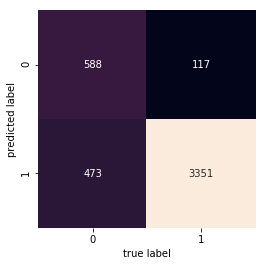

Area Under Curve: 0.93


/anaconda2/lib/python2.7/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


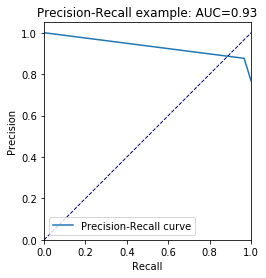

/anaconda2/lib/python2.7/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


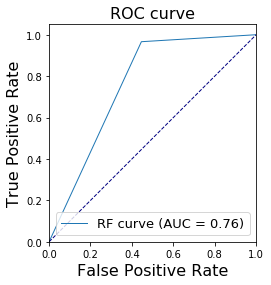

(array([[ 588,  473],
        [ 117, 3351]]),
 u'             precision    recall  f1-score   support\n\n          0       0.83      0.55      0.67      1061\n          1       0.88      0.97      0.92      3468\n\navg / total       0.87      0.87      0.86      4529\n')

In [28]:
def LogisticRegression_binary_classification(X_train, y_train, X_test, y_test):
    logisticRegr = LogisticRegression()
    logisticRegr.fit(X_train, y_train)
    predictions = logisticRegr.predict(X_test)
    Confusion_matrix = confusion_matrix(y_test, predictions)
    Classification_report = classification_report(y_test, predictions)
    print(confusion_matrix(y_test,predictions))
    print(classification_report(y_test, predictions))
    Accuracy_score = accuracy_score(y_test, predictions)
    print('Accuracy Score: {}'.format(Accuracy_score))
    F1_score = f1_score(y_test, predictions)
    print('F1 Score: {}'.format(F1_score))
    Average_precision = average_precision_score(y_test, predictions)
    print('Average precision-recall score: {}'.format(Average_precision))
    get_Confusion_Matrix(y_test, predictions)
    get_Precision_Recall(y_test, predictions)
    get_ROC(y_test, predictions)
    return Confusion_matrix, Classification_report

LogisticRegression_binary_classification(X_train, y_train, X_test, y_test)

## Logistic Regression for Binary Classification with Hyperparameter Tuning

[[ 588  473]
 [ 117 3351]]
             precision    recall  f1-score   support

          0       0.83      0.55      0.67      1061
          1       0.88      0.97      0.92      3468

avg / total       0.87      0.87      0.86      4529

Accuracy Score: 0.869728416869
F1 Score: 0.919089413055
Average precision-recall score: 0.872577040302


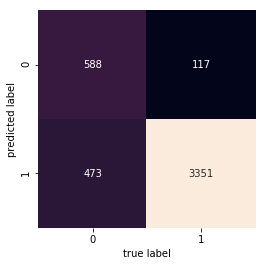

Area Under Curve: 0.93


/anaconda2/lib/python2.7/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


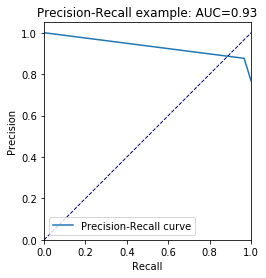

/anaconda2/lib/python2.7/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


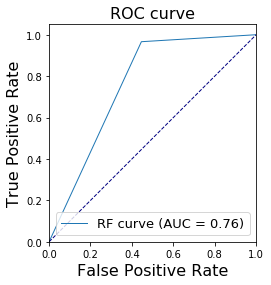

(array([[ 588,  473],
        [ 117, 3351]]),
 u'             precision    recall  f1-score   support\n\n          0       0.83      0.55      0.67      1061\n          1       0.88      0.97      0.92      3468\n\navg / total       0.87      0.87      0.86      4529\n')

In [29]:
def LogisticRegression_binary_classification_Tuned(X_train, y_train, X_test, y_test):
    logisticRegr = LogisticRegression()
    logisticRegr.fit(X_train, y_train)
    predictions = logisticRegr.predict(X_test)
    Confusion_matrix = confusion_matrix(y_test, predictions)
    Classification_report = classification_report(y_test, predictions)
    print(confusion_matrix(y_test,predictions))
    print(classification_report(y_test, predictions))
    Accuracy_score = accuracy_score(y_test, predictions)
    print('Accuracy Score: {}'.format(Accuracy_score))
    F1_score = f1_score(y_test, predictions)
    print('F1 Score: {}'.format(F1_score))
    Average_precision = average_precision_score(y_test, predictions)
    print('Average precision-recall score: {}'.format(Average_precision))
    get_Confusion_Matrix(y_test, predictions)
    get_Precision_Recall(y_test, predictions)
    get_ROC(y_test, predictions)
    return Confusion_matrix, Classification_report

LogisticRegression_binary_classification_Tuned(X_train, y_train, X_test, y_test)

## Logistic Regression for Three Classes 

Build Logistic Regression Classifier 
[[ 157  274   64]
 [  11 3420   37]
 [  66  427   73]]
             precision    recall  f1-score   support

          0       0.67      0.32      0.43       495
          1       0.83      0.99      0.90      3468
          2       0.42      0.13      0.20       566

avg / total       0.76      0.81      0.76      4529

Accuracy Score: 0.805917421064
F1 Score: 0.805917421064


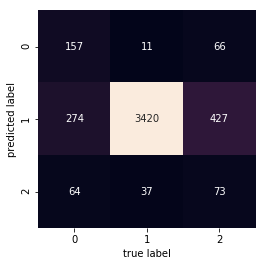

(18113, 47663)
(18113, 3)


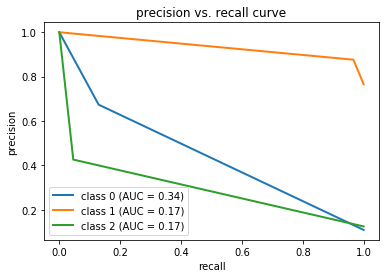

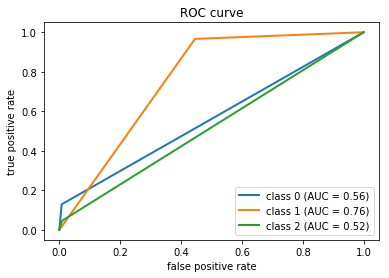

Average precision-recall score: 0.705428671619


0.7054286716186339

In [97]:
print("Build Logistic Regression Classifier ")
logisticRegr = OneVsRestClassifier(LogisticRegression(random_state=0))

def LogisticRegression_ThreeClass(X_train_3c, X_test_3c, y_train_3c, y_test_3c):    
    logisticRegr.fit(X_train_3c, y_train_3c)
    y_pred_3c = logisticRegr.predict(X_test_3c)
    Confusion_matrix = confusion_matrix(y_test_3c, y_pred_3c)
    Classification_report = classification_report(y_test_3c, y_pred_3c)
    print(confusion_matrix(y_test_3c, y_pred_3c))
    print(classification_report(y_test_3c, y_pred_3c))
    Accuracy_score = accuracy_score(y_test_3c, y_pred_3c)
    print('Accuracy Score: {}'.format(Accuracy_score))
    F1_score = f1_score(y_test_3c, y_pred_3c, average='micro')
    print('F1 Score: {}'.format(F1_score))
    get_Confusion_Matrix(y_test_3c, y_pred_3c)
    return Confusion_matrix

def LogisticRegression_ThreeClass_plots(X_train_dummy, X_test_dummy, y_train_dummy, y_test_dummy):
    print(X_train_dummy.shape)
    print(y_train_dummy.shape)
    logisticRegr.fit(X_train_dummy, y_train_dummy)
    y_pred_dummy = logisticRegr.predict(X_test_dummy)
    get_Precision_Recall_multiclass(y_test_dummy, y_pred_dummy)
    get_ROC_multiclass(y_test_dummy, y_pred_dummy)

    Average_precision = average_precision_score(y_test_dummy, y_pred_dummy, average='weighted')
    print('Average precision-recall score: {}'.format(Average_precision))
    return Average_precision
    
LogisticRegression_ThreeClass(X_train_3c, X_test_3c, y_train_3c, y_test_3c)  
LogisticRegression_ThreeClass_plots(X_train_dummy, X_test_dummy, y_train_dummy, y_test_dummy)

## Logistic Regression for Three Classes with Hyperparameter Tuning

Build Logistic Regression Classifier 
[[ 157  274   64]
 [  11 3420   37]
 [  66  427   73]]
             precision    recall  f1-score   support

          0       0.67      0.32      0.43       495
          1       0.83      0.99      0.90      3468
          2       0.42      0.13      0.20       566

avg / total       0.76      0.81      0.76      4529

Accuracy Score: 0.805917421064
F1 Score: 0.805917421064


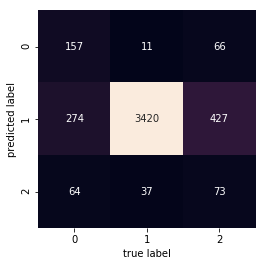

(18113, 47663)
(18113, 3)


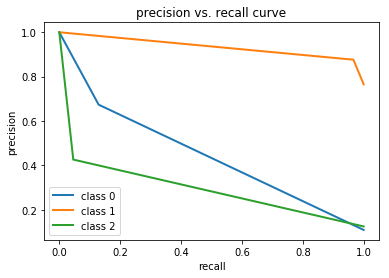

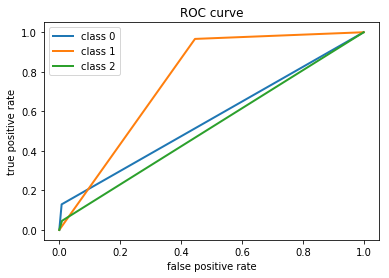

Average precision-recall score: 0.705428671619


0.7054286716186339

In [31]:
print("Build Logistic Regression Classifier ")
logisticRegr = OneVsRestClassifier(LogisticRegression(random_state=0))

def LogisticRegression_ThreeClass_Tuned(X_train_3c, X_test_3c, y_train_3c, y_test_3c):    
    logisticRegr.fit(X_train_3c, y_train_3c)
    y_pred_3c = logisticRegr.predict(X_test_3c)
    Confusion_matrix = confusion_matrix(y_test_3c, y_pred_3c)
    Classification_report = classification_report(y_test_3c, y_pred_3c)
    print(confusion_matrix(y_test_3c, y_pred_3c))
    print(classification_report(y_test_3c, y_pred_3c))
    Accuracy_score = accuracy_score(y_test_3c, y_pred_3c)
    print('Accuracy Score: {}'.format(Accuracy_score))
    F1_score = f1_score(y_test_3c, y_pred_3c, average='micro')
    print('F1 Score: {}'.format(F1_score))
    get_Confusion_Matrix(y_test_3c, y_pred_3c)
    return Confusion_matrix

def LogisticRegression_ThreeClass_plots_Tuned(X_train_dummy, X_test_dummy, y_train_dummy, y_test_dummy):
    print(X_train_dummy.shape)
    print(y_train_dummy.shape)
    logisticRegr.fit(X_train_dummy, y_train_dummy)
    y_pred_dummy = logisticRegr.predict(X_test_dummy)
    get_Precision_Recall_multiclass(y_test_dummy, y_pred_dummy)
    get_ROC_multiclass(y_test_dummy, y_pred_dummy)

    Average_precision = average_precision_score(y_test_dummy, y_pred_dummy, average='weighted')
    print('Average precision-recall score: {}'.format(Average_precision))
    return Average_precision
    
LogisticRegression_ThreeClass_Tuned(X_train_3c, X_test_3c, y_train_3c, y_test_3c)  
LogisticRegression_ThreeClass_plots_Tuned(X_train_dummy, X_test_dummy, y_train_dummy, y_test_dummy)

# Word2Vec

In [32]:
import en_core_web_lg
nlp1 = spacy.load('en_core_web_lg')

In [103]:
def tokenize(x):
    x= TextBlob(str(x)).words
    return x
df['Review Text w2v']=df['Review Text Precrocessed'].apply(lambda x: tokenize(x))

In [104]:
def get_vec(x):
    doc=nlp1(x)
    vec=doc.vector
    return vec

In [106]:
df['Review Vector']=df['Review Text w2v'].apply(lambda x: get_vec(x.encode('utf-8')))

AttributeError: 'WordList' object has no attribute 'encode'

In [67]:
df.head()

,index,Review Text,Rating,Recommended IND,Positive Feedback Count,Review Text Precrocessed,Char_Count,Word_Count,Label,Label_3C,Review Vector
0,0,Absolutely wonderful - silky and sexy and comf...,4,1,0,absolutely wonderful silky and sexy and comfor...,155,8,1,1,"[0.05038286, 0.040566426, -0.26723757, 0.09293..."
1,1,Love this dress! it's sooo pretty. i happene...,5,1,4,love this dress -PRON- is sooo pretty i happen...,971,62,1,1,"[-0.055735458, 0.24579218, -0.25002825, -0.012..."
2,2,I had such high hopes for this dress and reall...,3,0,0,i have such high hope for this dress and reall...,1589,98,0,2,"[-0.025143184, 0.120843865, -0.17390709, 0.033..."
3,3,"I love, love, love this jumpsuit. it's fun, fl...",5,1,0,i love love love this jumpsuit -PRON- is fun f...,381,22,1,1,"[0.027886605, 0.20771609, -0.1784711, -0.13507..."
4,4,This shirt is very flattering to all due to th...,5,1,6,this shirt is very flattering to all due to th...,601,36,1,1,"[0.059171822, 0.113866895, -0.1971494, 0.08237..."


In [36]:
df['Review Vector'].shape

(22642,)

In [54]:
word2vec = np.array(df['Review Vector'])

In [55]:
word2vec.shape

(22642,)

In [56]:
word2vec = word2vec.reshape(-1,1)

In [59]:
word2vec.shape

(22642, 1)

In [60]:
word2vec = np.concatenate(np.concatenate(word2vec, axis = 0), axis = 0).reshape(-1, 300)
word2vec.shape

(22642, 300)

In [110]:
import gensim
from gensim.models import Word2Vec

In [166]:
model = Word2Vec(df['Review Text w2v'], size=550, window=50, min_count=30, workers=10, iter=200)

In [167]:
def document_vector(doc):
    """Create document vectors by averaging word vectors. Remove out-of-vocabulary words."""
    doc = [word for word in doc if word in model.wv.vocab]
    return np.mean(model[doc], axis=0)


df['doc_vector'] = df['Review Text w2v'].apply(document_vector)
#test['doc_vector'] = df['Review Text w2v'].apply(document_vector)


/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:4: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  after removing the cwd from sys.path.


In [168]:
X = list(df['doc_vector'])

In [169]:
w2v_Y=df['Label']
w2v_X=X
w2vX_train, w2vX_test, w2vy_train, w2vy_test = train_test_split(w2v_X,w2v_Y, test_size=.20, random_state=101)

[[ 531  500]
 [ 319 3179]]
             precision    recall  f1-score   support

          0       0.62      0.52      0.56      1031
          1       0.86      0.91      0.89      3498

avg / total       0.81      0.82      0.81      4529

Accuracy Score: 0.819165378671
F1 Score: 0.885885467466
Average precision-recall score: 0.855727498383


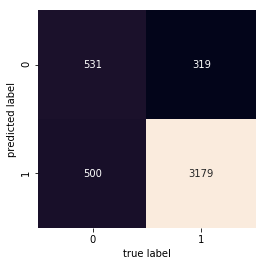

Area Under Curve: 0.92


/anaconda2/lib/python2.7/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


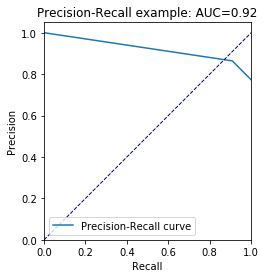

/anaconda2/lib/python2.7/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


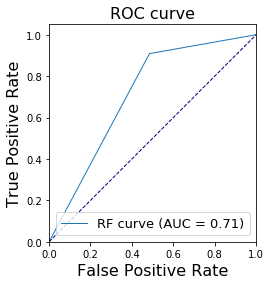

(array([[ 531,  500],
        [ 319, 3179]]),
 u'             precision    recall  f1-score   support\n\n          0       0.62      0.52      0.56      1031\n          1       0.86      0.91      0.89      3498\n\navg / total       0.81      0.82      0.81      4529\n')

In [170]:
RandomForestBinaryClassifier(w2vX_train, w2vy_train, w2vX_test, w2vy_test)

[[ 362  669]
 [ 192 3306]]
             precision    recall  f1-score   support

          0       0.65      0.35      0.46      1031
          1       0.83      0.95      0.88      3498

avg / total       0.79      0.81      0.79      4529

Accuracy Score: 0.809891808346
F1 Score: 0.884785226817
Average precision-recall score: 0.828440909242


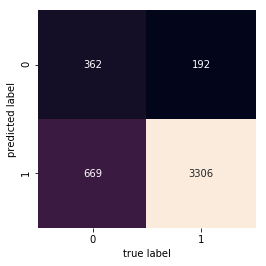

Area Under Curve: 0.91


/anaconda2/lib/python2.7/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


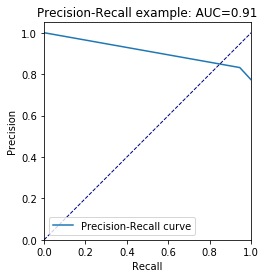

/anaconda2/lib/python2.7/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


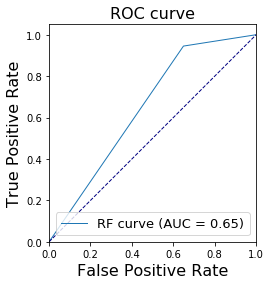

(array([[ 362,  669],
        [ 192, 3306]]),
 u'             precision    recall  f1-score   support\n\n          0       0.65      0.35      0.46      1031\n          1       0.83      0.95      0.88      3498\n\navg / total       0.79      0.81      0.79      4529\n')

In [70]:
RandomForestBinaryClassifierTuned(w2vX_train, w2vy_train, w2vX_test, w2vy_test, 300)

In [73]:
w2v_y_3c=df['Label_3C']
w2v_X_3c=word2vec

w2v_X_train_3c, w2v_X_test_3c, w2v_y_train_3c, w2v_y_test_3c = train_test_split(w2v_X_3c, w2v_y_3c ,test_size=.20, random_state=0)
print(df['Label_3C'].value_counts())

1    17449
2     2823
0     2370
Name: Label_3C, dtype: int64


In [74]:
w2v_y_dummy=label_binarize(w2v_y_3c, classes=[0,1,2])
w2v_X_3c=word2vec
w2v_X_train_dummy, w2v_X_test_dummy, w2v_y_train_dummy, w2v_y_test_dummy = train_test_split(w2v_X_3c, w2v_y_dummy ,test_size=.20, random_state=0)

[[  74  350   46]
 [  69 3371   58]
 [  51  477   33]]
             precision    recall  f1-score   support

          0       0.38      0.16      0.22       470
          1       0.80      0.96      0.88      3498
          2       0.24      0.06      0.09       561

avg / total       0.69      0.77      0.71      4529

Accuracy Score: 0.767939942592
F1 Score: 0.767939942592


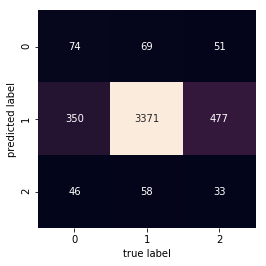

(18113, 300)
(18113, 3)


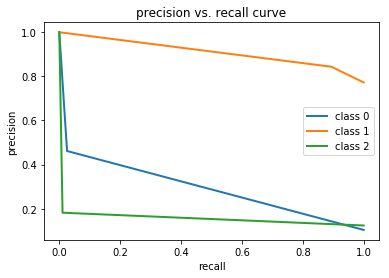

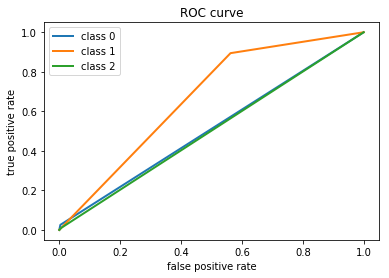

Average precision-recall score: 0.67286377692


0.6728637769204231

In [75]:
RandomForest_ThreeClass(w2v_X_train_3c, w2v_X_test_3c, w2v_y_train_3c, w2v_y_test_3c)  
RandomForest_ThreeClass_plots(w2v_X_train_dummy, w2v_X_test_dummy, w2v_y_train_dummy, w2v_y_test_dummy)

[[  73  341   56]
 [  37 3403   58]
 [  25  478   58]]
             precision    recall  f1-score   support

          0       0.54      0.16      0.24       470
          1       0.81      0.97      0.88      3498
          2       0.34      0.10      0.16       561

avg / total       0.72      0.78      0.73      4529

Accuracy Score: 0.780304703025
F1 Score: 0.780304703025


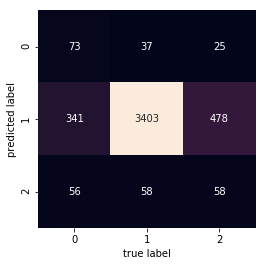

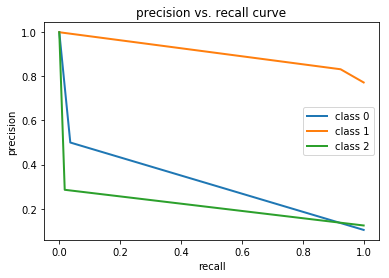

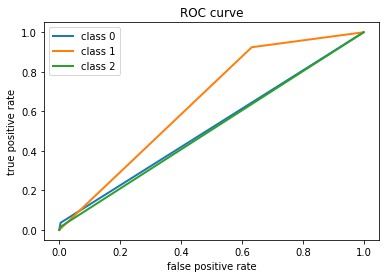

Average precision-recall score: [0.11810719 0.82764328 0.12675336]


array([0.11810719, 0.82764328, 0.12675336])

In [76]:
RandomForest_ThreeClass_Tuned(w2v_X_train_3c, w2v_X_test_3c, w2v_y_train_3c, w2v_y_test_3c, 300)  
RandomForest_ThreeClass_Tuned_plots(w2v_X_train_dummy, w2v_X_test_dummy, w2v_y_train_dummy, w2v_y_test_dummy, 300)

# Testing

In [ ]:
#negative sentiment indices
Negatives=df[df['Label']==0].index.tolist()

#positive sentiment indices
Positives=df[df['Label']==1].index.tolist()


In [ ]:
## Positive Review Testing

In [ ]:
val=random.choice(Positives)
Test_sentence = df.loc[ (df['Label'] == 1) & (df['index'] == val) , 'Review Text']

In [ ]:
## Negative Review Testing

In [ ]:
val=random.choice(Negatives)
Test_sentence = df.loc[ (df['Label'] == 0) & (df['index'] == val) , 'Review Text']

In [ ]:
## Test Your Own Sentence

In [98]:
Test_sentence =["This dress is very good but color is bad"]

In [ ]:
## Test According to Customer ID

In [ ]:
Test_sentence = df.loc[df['index'] == 10 , 'Review Text']

In [99]:
Test_sentence

['This dress is very good but color is bad']

In [100]:
pd.set_option('display.max_colwidth', 1000)
print("Original Review")
print(Test_sentence)
print("\n")


print("Actual Label")
Actual_label= df.loc[df['index'] == val , 'Label']
print(Actual_label)
print("\n")

def prediction(x):
    x=df.loc[df['index'] == val , 'Review Text Precrocessed']
    X=tfidf.transform(x)
    pred=clf.predict(X)
    if pred==0:
      return 'Negative'
    else:
      return 'Positive'

prediction(Test_sentence)

Original Review
['This dress is very good but color is bad']


Actual Label


NameError: name 'val' is not defined

In [72]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB  
model = MultinomialNB()  
nv = model.fit(X_train.toarray(), y_train)
nv_pred=nv.predict(X_test.toarray())
cm=confusion_matrix(y_test,nv_pred)
print(confusion_matrix(y_test,nv_pred))
print(classification_report(y_test,nv_pred)) 
print(accuracy_score(y_test,nv_pred))

[[ 127  934]
 [   6 3462]]
             precision    recall  f1-score   support

          0       0.95      0.12      0.21      1061
          1       0.79      1.00      0.88      3468

avg / total       0.83      0.79      0.72      4529

0.7924486641642747
